In [24]:
'''
=====Experiment=====
Dataset: CIC-IDS-2017 dataset

Training with whole graph
Downsampled 90% normal traffic randomly
Split train and test randomly

Combined IP and Port features
'''

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Datasets.CIC_IDS_2017.CIC_IDS_2017_config import CIC_IDS_2017_Config

In [25]:
csv_file_name = "all_downsampled"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"CIC_IDS_2017/All/{csv_file_name}.csv"))

DATASET_NAME = "CIC_IDS_2017"
EXPERIMENT_NAME = "whole_graph_combined_ports"

SOURCE_IP_COL_NAME = CIC_IDS_2017_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = CIC_IDS_2017_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = CIC_IDS_2017_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = CIC_IDS_2017_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = CIC_IDS_2017_Config.ATTACK_CLASS_COL_NAME

BENIGN_CLASS_NAME = CIC_IDS_2017_Config.BENIGN_CLASS_NAME

TIME_COLS = CIC_IDS_2017_Config.TIME_COL_NAMES

print(data[ATTACK_CLASS_COL_NAME].value_counts())

MULTICLASS = True

label_col = ATTACK_CLASS_COL_NAME

saves_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, EXPERIMENT_NAME)

checkpoint_path = os.path.join(saves_path, f"checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(saves_path, f"best_model_{csv_file_name}.pth")

os.makedirs(saves_path, exist_ok=True)

Label
DoS Hulk                      231073
BENIGN                        227310
PortScan                      158930
DDoS                          128027
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack - Brute Force        1507
Web Attack - XSS                 652
Infiltration                      36
Web Attack - Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64


In [26]:
data.drop(columns=CIC_IDS_2017_Config.DROP_COLS,inplace=True)
data.drop(columns=CIC_IDS_2017_Config.TIME_COL_NAMES)
print(data.columns)

Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Length of Fwd Packets', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Min',
       'Bwd Packet Length Std', 'Flow Packets/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Min', 'Bwd IAT Mean',
       'Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'Average Packet Size', 'Fwd Header Length.1', 'Subflow Fwd Packets',
       'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Active Mean', 'Active Min', 'Label', 'source_file_id'],
      dtype='object')


In [27]:
data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

# # Combine Port and IP
data[SOURCE_PORT_COL_NAME] = data[SOURCE_PORT_COL_NAME].apply(str)
data[DESTINATION_PORT_COL_NAME] = data[DESTINATION_PORT_COL_NAME].apply(str)

data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME] + ':' + data[SOURCE_PORT_COL_NAME]
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME] + ':' + data[DESTINATION_PORT_COL_NAME]
data.drop(columns=[SOURCE_PORT_COL_NAME,DESTINATION_PORT_COL_NAME],inplace=True)

data = pd.get_dummies(data, columns = CIC_IDS_2017_Config.CATEGORICAL_COLS) # One Hot Encoding for categorical data
converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CIC_IDS_2017_Config.CATEGORICAL_COLS))]

In [28]:
print(data.head)

<bound method NDFrame.head of                                          Flow ID              Source IP  \
0        192.168.10.14-23.208.79.179-51174-443-6  192.168.10.14_4:51174   
1           192.168.10.5-72.247.71.12-53469-80-6      72.247.71.12_7:80   
2       192.168.10.17-104.19.194.102-58257-443-6  192.168.10.17_4:58257   
3          192.168.10.8-93.184.215.13-58377-80-6   192.168.10.8_4:58377   
4        192.168.10.12-34.198.61.240-40382-443-6    34.198.61.240_1:443   
...                                          ...                    ...   
784951      172.16.0.1-192.168.10.50-42006-445-6     172.16.0.1_7:42006   
784952       172.16.0.1-192.168.10.50-57546-80-6     172.16.0.1_7:57546   
784953      172.16.0.1-192.168.10.50-49768-139-6     172.16.0.1_7:49768   
784954     172.16.0.1-192.168.10.50-44870-2000-6     172.16.0.1_7:44870   
784955       172.16.0.1-192.168.10.50-57546-80-6     172.16.0.1_7:57546   

               Destination IP            Timestamp  Flow Duration  \


In [29]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)
data.drop(columns=['index'],inplace=True)
print(data.head)

<bound method NDFrame.head of                                          Flow ID              Source IP  \
0        192.168.10.14-23.208.79.179-51174-443-6  192.168.10.14_4:51174   
1           192.168.10.5-72.247.71.12-53469-80-6      72.247.71.12_7:80   
2       192.168.10.17-104.19.194.102-58257-443-6  192.168.10.17_4:58257   
3          192.168.10.8-93.184.215.13-58377-80-6   192.168.10.8_4:58377   
4        192.168.10.12-34.198.61.240-40382-443-6    34.198.61.240_1:443   
...                                          ...                    ...   
784951      172.16.0.1-192.168.10.50-42006-445-6     172.16.0.1_7:42006   
784952       172.16.0.1-192.168.10.50-57546-80-6     172.16.0.1_7:57546   
784953      172.16.0.1-192.168.10.50-49768-139-6     172.16.0.1_7:49768   
784954     172.16.0.1-192.168.10.50-44870-2000-6     172.16.0.1_7:44870   
784955       172.16.0.1-192.168.10.50-57546-80-6     172.16.0.1_7:57546   

               Destination IP            Timestamp  Flow Duration  \


In [30]:
scaler = StandardScaler()
cols_to_norm = CIC_IDS_2017_Config.COLS_TO_NORM
print(data[cols_to_norm].describe()) # Check if there's any too large value

       Bwd Packet Length Min  Subflow Fwd Packets  \
count          784956.000000        784956.000000   
mean               16.079970             5.867280   
std                47.215745           423.380115   
min                 0.000000             1.000000   
25%                 0.000000             1.000000   
50%                 0.000000             3.000000   
75%                 6.000000             6.000000   
max              2896.000000        209916.000000   

       Total Length of Fwd Packets  Fwd Packet Length Mean  \
count                 7.849560e+05           784956.000000   
mean                  3.177689e+02               36.806877   
std                   6.370183e+03              124.200090   
min                   0.000000e+00                0.000000   
25%                   2.000000e+00                2.000000   
50%                   2.600000e+01                8.666667   
75%                   3.220000e+02               47.000000   
max                   2.86

In [31]:
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Try to clip the column
            df[col] = df[col].clip(lower=-1e9, upper=1e9)
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, CIC_IDS_2017_Config.COLS_TO_NORM)


✅ All other columns processed successfully.


In [32]:
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [33]:
from sklearn.preprocessing import LabelEncoder

num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)


['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack - Brute Force' 'Web Attack - Sql Injection'
 'Web Attack - XSS']
Attack label mapping: {'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack - Brute Force': 12, 'Web Attack - Sql Injection': 13, 'Web Attack - XSS': 14}


In [34]:
# 70% train, 15% validation, 15% test
train_full_df, test_df = train_test_split(
     data, test_size=0.15, random_state=42, stratify=data[label_col])


feature_cols = cols_to_norm + converted_categorical_cols

print('Feature Columns:', feature_cols)

train_full_df['h'] = train_full_df[ feature_cols ].values.tolist()
test_df['h'] = test_df[ feature_cols ].values.tolist()

y_train = train_full_df[label_col]
y_test = test_df[label_col]

pd.set_option('display.max_columns', None)

print("Number of training samples:", len(train_full_df))
print(y_train.value_counts())
print("Number of test samples:", len(test_df))
print(y_test.value_counts())

print(train_full_df.head(5))

Feature Columns: ['Bwd Packet Length Min', 'Subflow Fwd Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Mean', 'Total Length of Fwd Packets', 'Fwd Packet Length Std', 'Fwd IAT Min', 'Flow IAT Min', 'Flow IAT Mean', 'Bwd Packet Length Std', 'Subflow Fwd Bytes', 'Flow Duration', 'Flow IAT Std', 'Active Min', 'Active Mean', 'Bwd IAT Mean', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'ACK Flag Count', 'Fwd PSH Flags', 'SYN Flag Count', 'Flow Packets/s', 'PSH Flag Count', 'Average Packet Size', 'Protocol_0', 'Protocol_6', 'Protocol_17']
Number of training samples: 667212
Label
4     196412
0     193213
10    135090
2     108823
3       8749
7       6747
11      5013
6       4927
5       4674
1       1671
12      1281
14       554
9         31
13        18
8          9
Name: count, dtype: int64
Number of test samples: 117744
Label
4     34661
0     34097
10    23840
2     19204
3      1544
7      1191
11      884
6       869
5       825
1       295
12      226
14       98
9   

In [35]:
def create_graph(df, source_ip_col, destination_ip_col, edge_attr, create_using=nx.MultiDiGraph(), **kwargs):
    G_nx = nx.from_pandas_edgelist(df, source_ip_col, destination_ip_col, edge_attr, create_using=create_using, **kwargs)
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    print("Number of edges in G_pyg:", num_edges)
    print("Number of node in G_pyg:", num_nodes)
    print("Shape of node in G_pyg:", G_pyg.x.shape)
    print("Shape of edge attr in G_pyg:", G_pyg.edge_attr.shape)
    print("Shape of edge label in G_pyg:", G_pyg.edge_label.shape)

    return G_nx, G_pyg

In [36]:
G_nx_test, G_pyg_test = create_graph(test_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

Number of edges in G_pyg: 117744
Number of node in G_pyg: 82944
Shape of node in G_pyg: torch.Size([82944, 27])
Shape of edge attr in G_pyg: torch.Size([117744, 27])
Shape of edge label in G_pyg: torch.Size([117744])


In [37]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [38]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [39]:
th.cuda.empty_cache()

In [40]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

In [41]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(data, epochs, learning_rates, hidden_dims, drop_outs):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    best_params = {}
    best_f1 = 0

    # Precompute the train and validation graphs for all folds
    folds = []
    for train_idx, val_idx in skf.split(data, data[label_col]):
        train_df = data.iloc[train_idx]
        val_df = data.iloc[val_idx]

        G_nx_train, G_pyg_train = create_graph(train_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
        G_nx_val, G_pyg_val = create_graph(val_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

        G_pyg_train = G_pyg_train.to(device)
        G_pyg_val = G_pyg_val.to(device)

        G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
        G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

        G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
        G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

        folds.append((G_pyg_train, G_pyg_val))

    params_results = {}
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}, drop_out: {drop_out}")
                fold_f1_scores = []

                for fold, (G_pyg_train, G_pyg_val) in enumerate(folds):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=G_pyg_train.num_node_features,
                                    edge_in_channels=G_pyg_train.num_edge_features,
                                    hidden_channels=hidden_dim,
                                    dropout=drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    labels = G_pyg_train.edge_label.cpu().numpy()
                    class_weights = class_weight.compute_class_weight('balanced',
                                                                    classes=np.unique(labels),
                                                                    y=labels)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)
                    scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

                    best_epoch_f1 = 0  # Track the best F1 score for this fold

                    for epoch in range(epochs):
                        train_loss = 0
                        val_loss = 0

                        try:
                            model.train()
                            out = model(G_pyg_train)
                            
                            optimizer.zero_grad()
                            loss = criterion(out, G_pyg_train.edge_label)
                            train_loss = loss.item()

                            loss.backward()
                            optimizer.step()
                            scheduler.step()

                            model.eval()
                            with th.no_grad():
                                out = model(G_pyg_val)
                                loss = criterion(out, G_pyg_val.edge_label)
                                val_loss = loss.item()

                            val_f1 = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='weighted')

                            if val_f1 > best_epoch_f1:
                                best_epoch_f1 = val_f1  # Update the best F1 score for this fold
                                print(f"Best F1 Score at epoch {epoch}: {best_epoch_f1:.4f}, Parameters: lr={lr}, hidden_dim={hidden_dim}, drop_out={drop_out}")

                            if epoch % 100 == 0:
                                print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print("Current Results: ", params_results)
                print(f"Average F1 Score for dropout {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

        print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
        print("All results:", params_results)


learning_rates = [0.05, 0.01, 0.001]
hidden_dims = [128, 256, 512]
drop_outs = [0.2, 0.3, 0.4]

grid_search(train_full_df, epochs=200, learning_rates=learning_rates, hidden_dims=hidden_dims, drop_outs=drop_outs)


Number of edges in G_pyg: 444808
Number of node in G_pyg: 210429
Shape of node in G_pyg: torch.Size([210429, 27])
Shape of edge attr in G_pyg: torch.Size([444808, 27])
Shape of edge label in G_pyg: torch.Size([444808])
Number of edges in G_pyg: 222404
Number of node in G_pyg: 131014
Shape of node in G_pyg: torch.Size([131014, 27])
Shape of edge attr in G_pyg: torch.Size([222404, 27])
Shape of edge label in G_pyg: torch.Size([222404])
Number of edges in G_pyg: 444808
Number of node in G_pyg: 210327
Shape of node in G_pyg: torch.Size([210327, 27])
Shape of edge attr in G_pyg: torch.Size([444808, 27])
Shape of edge label in G_pyg: torch.Size([444808])
Number of edges in G_pyg: 222404
Number of node in G_pyg: 130990
Shape of node in G_pyg: torch.Size([130990, 27])
Shape of edge attr in G_pyg: torch.Size([222404, 27])
Shape of edge label in G_pyg: torch.Size([222404])
Number of edges in G_pyg: 444808
Number of node in G_pyg: 210307
Shape of node in G_pyg: torch.Size([210307, 27])
Shape of e

In [42]:
train_df, val_df = train_test_split(
     train_full_df, test_size=0.15, random_state=42, stratify=train_full_df[label_col])

G_nx_train, G_pyg_train = create_graph(train_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
G_nx_val, G_pyg_val = create_graph(val_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())


Number of edges in G_pyg: 567130
Number of node in G_pyg: 246698
Shape of node in G_pyg: torch.Size([246698, 27])
Shape of edge attr in G_pyg: torch.Size([567130, 27])
Shape of edge label in G_pyg: torch.Size([567130])
Number of edges in G_pyg: 100082
Number of node in G_pyg: 73716
Shape of node in G_pyg: torch.Size([73716, 27])
Shape of edge attr in G_pyg: torch.Size([100082, 27])
Shape of edge label in G_pyg: torch.Size([100082])


In [43]:
import pickle

def save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs):
    global checkpoint_path, train_loss_history_path, val_loss_history_path, val_f1_history_path, saved_model_epochs_path

    # Save checkpoint
    th.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_f1': best_f1
    }, checkpoint_path)
    with open(train_loss_history_path, 'wb') as f:
        pickle.dump(train_loss_history, f)
    with open(val_loss_history_path, 'wb') as f:
        pickle.dump(val_loss_history, f)
    with open(val_f1_history_path, 'wb') as f:
        pickle.dump(val_f1_history, f)
    with open(saved_model_epochs_path, 'wb') as f:
        pickle.dump(saved_model_epochs, f)

In [44]:
# Extract the best parameters from the grid search
best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.01  # Replace with the best learning_rate found
best_dropout = 0.3  # Replace with the best dropout found
epochs = 1000

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=G_pyg_train.num_node_features,
                   edge_in_channels=G_pyg_train.num_edge_features,
                   hidden_channels=best_hidden_dim,
                   dropout=best_dropout,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Compute class weights for the training dataset
labels = G_pyg_train.edge_label.cpu().numpy()
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)

# Normalize class weights
class_weights = th.FloatTensor(class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# Move the graph data to the device
G_pyg_train = G_pyg_train.to(device)
G_pyg_val = G_pyg_val.to(device)

G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

# ===== Load checkpoint if exists =====
best_f1 = 0
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"Resumed training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

train_loss_history_path = os.path.join(saves_path, 'train_loss_history.pkl')
val_loss_history_path = os.path.join(saves_path, 'val_loss_history.pkl')
val_f1_history_path = os.path.join(saves_path, 'val_f1_history.pkl')
saved_model_epochs_path = os.path.join(saves_path, 'saved_model_epochs.pkl')

if os.path.exists(train_loss_history_path) and os.path.exists(val_loss_history_path) and os.path.exists(val_f1_history_path) and os.path.exists(saved_model_epochs_path):
    with open(train_loss_history_path, 'rb') as f:
        train_loss_history = pickle.load(f)
    with open(val_loss_history_path, 'rb') as f:
        val_loss_history = pickle.load(f)
    with open(val_f1_history_path, 'rb') as f:
        val_f1_history = pickle.load(f)
    with open(saved_model_epochs_path, 'rb') as f:
        saved_model_epochs = pickle.load(f)

# ===== Start Training =====
for epoch in range(start_epoch, epochs):
    train_loss = 0
    val_loss = 0

    model.train()
    out = model(G_pyg_train)

    optimizer.zero_grad()
    loss = criterion(out, G_pyg_train.edge_label)
    train_loss = loss.item()

    loss.backward()
    optimizer.step()
    scheduler.step()

    model.eval()
    with th.no_grad():
        out = model(G_pyg_val)
        loss = criterion(out, G_pyg_val.edge_label)
        val_loss = loss.item()

    val_f1 = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='weighted')
    val_f1_micro = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='micro')
    val_f1_macro = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='macro')

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

    if val_f1 > best_f1:
        best_f1 = val_f1  # Update the best F1 score for this fold
        best_model_state = model.state_dict()
        saved_model_epochs.append(epoch)

        save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)
        th.save(best_model_state, best_model_path)
        print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

    if epoch % 10 == 0:
        # Save checkpoint
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')
        save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

# Save the trained model
print("Model training completed and saved.")

Class weights: tensor([2.3022e-01, 2.6626e+01, 4.0874e-01, 5.0839e+00, 2.2647e-01, 9.5164e+00,
        9.0279e+00, 6.5926e+00, 4.7261e+03, 1.4542e+03, 3.2927e-01, 8.8732e+00,
        3.4719e+01, 2.5206e+03, 8.0273e+01], device='cuda:0')
Epoch 0 Saved best model. Best F1: 0.2571016620963626
Epoch 0, Train Loss: 2.7890, Validation Loss: 2.6797, Validation F1: 0.2571
Epoch 3 Saved best model. Best F1: 0.4387425614379881
Epoch 6 Saved best model. Best F1: 0.4600938033840539
Epoch 8 Saved best model. Best F1: 0.4756714192000096
Epoch 9 Saved best model. Best F1: 0.7002458485099385
Epoch 10, Train Loss: 1.2235, Validation Loss: 1.1883, Validation F1: 0.4942
Epoch 13 Saved best model. Best F1: 0.7521367175512521
Epoch 20, Train Loss: 0.9194, Validation Loss: 0.9915, Validation F1: 0.4728
Epoch 30, Train Loss: 0.8178, Validation Loss: 1.0396, Validation F1: 0.4646
Epoch 38 Saved best model. Best F1: 0.755095022701912
Epoch 40, Train Loss: 0.6719, Validation Loss: 0.9641, Validation F1: 0.5054


KeyboardInterrupt: 

In [45]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_losses, label='Train Loss', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_losses))

    plt.tight_layout()
    plt.show()

61


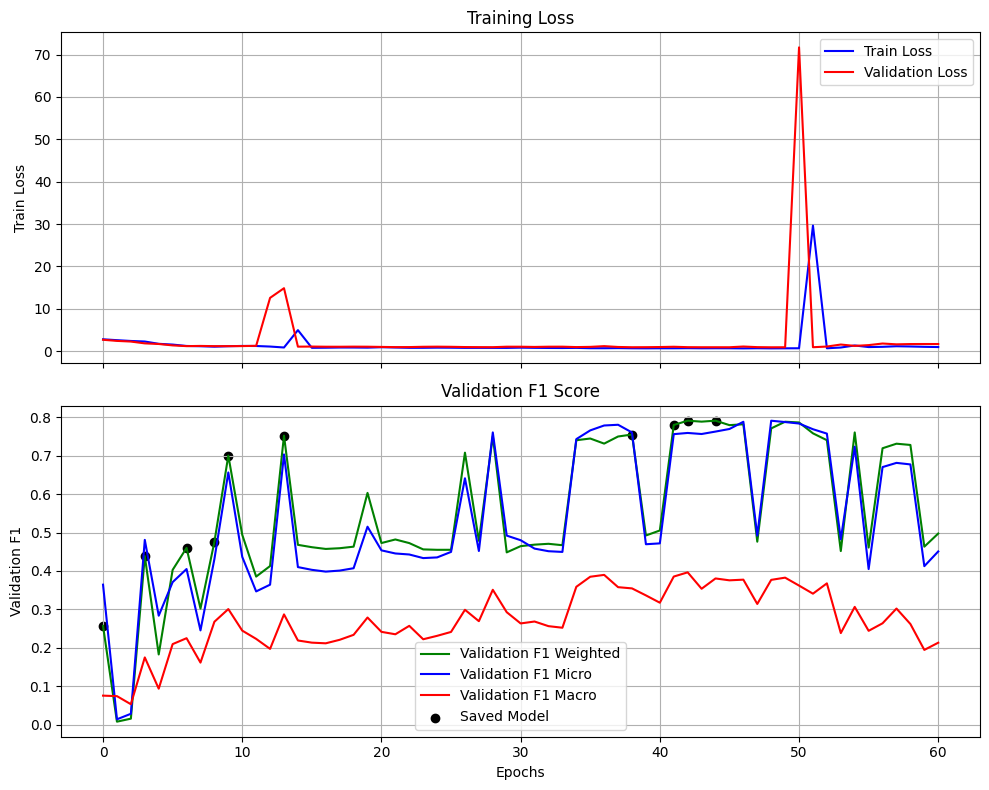

In [46]:
plot_training_process(train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

In [47]:
G_nx_test, G_pyg_test = create_graph(test_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

Number of edges in G_pyg: 117744
Number of node in G_pyg: 82944
Shape of node in G_pyg: torch.Size([82944, 27])
Shape of edge attr in G_pyg: torch.Size([117744, 27])
Shape of edge label in G_pyg: torch.Size([117744])


In [48]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(G_pyg_test, adversarial=False):

    G_pyg_test = G_pyg_test.to(device)
    G_pyg_test.edge_label = G_pyg_test.edge_label.to(device)
    G_pyg_test.edge_attr = G_pyg_test.edge_attr.to(device)

    best_model = EGraphSAGE(node_in_channels=G_pyg_test.num_node_features, 
                       edge_in_channels=G_pyg_test.num_edge_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path))
    best_model = best_model.to(device)

    best_model.eval()

    print("inference start")
    with th.no_grad():
            
        try:
            out = best_model(G_pyg_test)
            
        except Exception as forward_error:
            print(f"Error during forward/backward pass at {forward_error}")

    print("inference done")

    pred_labels = out.argmax(dim=1).cpu()
    all_test_labels = G_pyg_test.edge_label.cpu()

    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]
        
        

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)


    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4)
    print(report)

    
eval(G_pyg_test)


Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/CIC_IDS_2017/whole_graph_combined_ports/best_model_all_downsampled.pth
inference start
inference done
class_map ['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack - Brute Force' 'Web Attack - Sql Injection'
 'Web Attack - XSS']
[[27323   614    87     2     6     1     0  1154     3    52   210  4173
      9    72   391]
 [    0   295     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     0 19203     0     0     0     1     0     0     0     0     0
      0     0     0]
 [    0     0     0     0  1541     1     2     0     0     0     0     0
      0     0     0]
 [    0     0     0    12 34510    12   127     0     0     0     0     0
      0     0     0]
 [    0     0     0     0   818     0     7     0     0     0     0     0
      0     0    

In [49]:
def inject_traffic_to_attacker(graph, ratio=0.1, num_injected_nodes=1, is_attack=False):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # 1. Identify attacker nodes
    attacker_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
    attacker_nodes = th.unique(edge_index[:, attacker_edges])
    if attacker_nodes.numel() == 0:
        raise ValueError("No attacker nodes found.")

    # 2. Sample benign edge feature pool
    if is_attack:
        attack_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[attack_edges]
    else:
        benign_edges = (edge_label == BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[benign_edges]

    # 3. Inject new nodes
    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    
    for _ in range(num_to_inject):
        src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes

        dst = attacker_nodes[random.randint(0, len(attacker_nodes) - 1)].item()

        new_edges.append([src, dst])
        attr = inject_edge_attr_pool[random.randint(0, len(inject_edge_attr_pool) - 1)]
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

        # new_graph.first_injected_node_idx = original_num_nodes # Store injected node indices

    return new_graph


In [50]:
# Inject Attack Traffic to Attacker Nodes
G_pyg_test = G_pyg_test.cpu()
injected_graph = inject_traffic_to_attacker(G_pyg_test, 0.1, num_injected_nodes=1, is_attack=True)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/CIC_IDS_2017/whole_graph_combined_ports/best_model_all_downsampled.pth
inference start
inference done
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0 

In [51]:
# Inject BENIGN Traffic to Attacker Nodes
injected_graph = inject_traffic_to_attacker(G_pyg_test, 0.1, num_injected_nodes=1, is_attack=False)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/CIC_IDS_2017/whole_graph_combined_ports/best_model_all_downsampled.pth
inference start
inference done
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0 

In [52]:
def inject_random_nodes(graph, ratio=0.1, num_injected_nodes=1):
	edge_index = graph.edge_index.clone()
	edge_attr = graph.edge_attr.clone()
	edge_label = graph.edge_label.clone()
	x = graph.x.clone()

	num_edges = edge_index.size(1)
	feature_dim = graph.x.size(1)

	# 1. Inject new nodes
	original_num_nodes = x.size(0)
	new_node_feats = th.ones((num_injected_nodes, feature_dim))
	x = th.cat([x, new_node_feats], dim=0)

	# 2. Inject random edges
	num_to_inject = max(1, int(ratio * num_edges))
	new_edges = []
	new_attrs = []
	new_labels = []

	for _ in range(num_to_inject):
		src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
		dst = random.randint(0, original_num_nodes - 1)  # to existing nodes

		new_edges.append([src, dst])
		attr = edge_attr[random.randint(0, len(edge_attr) - 1)]  # Randomly sample edge attributes
		new_attrs.append(attr)
		new_labels.append(ADVERSARIAL_CLASS_LABEL)  # Assign benign class label to new edges

	# 3. Merge into graph
	if new_edges:
		new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
		new_attrs = th.stack(new_attrs)
		new_labels = th.tensor(new_labels, dtype=th.long)

		edge_index = th.cat([edge_index, new_edges], dim=1)
		edge_attr = th.cat([edge_attr, new_attrs], dim=0)
		edge_label = th.cat([edge_label, new_labels], dim=0)

	# Create a new graph with the injected nodes and edges
	new_graph = Data(
		edge_index=edge_index,
		edge_attr=edge_attr,
		edge_label=edge_label,
		x=x
	)

	return new_graph

In [53]:
# Inject Random Nodes in the graph
injected_graph = inject_random_nodes(G_pyg_test, 0.1, num_injected_nodes=1)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/CIC_IDS_2017/whole_graph_combined_ports/best_model_all_downsampled.pth
inference start
inference done
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0 